In [1]:
%env CUDA_VISIBLE_DEVICES=6
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import copy
import torch
import matplotlib.pyplot as plt
from torch.nn.functional import interpolate

from utils.visualization import display_image_pair
from utils.model import read_model_config, load_model
from utils.dataset import read_dataset_config, load_dataset, Preprocessor

In [41]:
analysis_type = 'layers' # 'layers', 'timesteps', 'combination', 'dino'

if analysis_type == 'layers':
    model_name = 'diff_add_analysis_layers'
elif analysis_type == 'timesteps':
    model_name = 'diff_add_analysis_timesteps'
elif analysis_type == 'combination':
    model_name = 'combination_add_analysis'
elif analysis_type == 'dino':
    model_name = 'dinov2_analysis'

#model_name = "dit_add_analysis_layers" # REMOVE LATER
#model_name = "ijepa" # REMOVE LATER
model_name = "combination_1-5"

dataset_config = '../dataset_config.yaml'
model_config = '../eval_config.yaml'
device_type = 'cuda'
pck_threshold = 0.1

In [42]:
# Load model config
model_config = read_model_config(model_config)[model_name]
model_config['output_all'] = True # for combination_add_analysis

# Get model parameters
image_size = model_config.get('image_size', (768, 768))
grad_enabled = model_config.get('grad_enabled', False)
rescale_data = model_config.get('rescale_data', False)
image_range = model_config.get('image_range', (-1, 1))

# Load model
model = load_model(model_name, model_config)

# Move model to device
device = torch.device(device_type)
model.to(device)

# Load dataset config
dataset_config = read_dataset_config(dataset_config)

# Define preprocessor
preprocess = Preprocessor(image_size, image_range=image_range, rescale_data=rescale_data)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Using cache found in /export/home/ra63des/.cache/torch/hub/facebookresearch_dinov2_main


Evaluating dataset: S2K


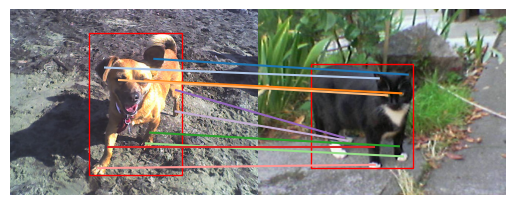

In [43]:
# Evaluate
dataset_name = "S2K"
print(f"Evaluating dataset: {dataset_name}")
config = dataset_config[dataset_name]
config['only_non_unique'] = True
dataset = load_dataset(dataset_name, config)

# Take first sample
unprocessed_sample = dataset[7]

# Visualize sample
display_image_pair(unprocessed_sample, show_bbox=True)

# Preprocess sample
sample = preprocess(copy.deepcopy(unprocessed_sample))

def batchify(sample):
    batch = {}
    for key in sample:
        if key in ['source_image', 'target_image', 'source_bbox', 'target_bbox']:
            batch[key] = sample[key].unsqueeze(0)
        else:
            batch[key] = [sample[key]]
    return batch

# Batchify sample
batch = batchify(sample)

# load images on device
batch['source_image'] = batch['source_image'].to(device)
batch['target_image'] = batch['target_image'].to(device)

In [44]:
# run through model

import time

n = 1
time_elapsed = 0
for i in range(n):
    start = time.time()
    with torch.set_grad_enabled(grad_enabled):
        source_features = model.get_features(batch['source_image'], batch['source_category'])
        target_features = model.get_features(batch['target_image'], batch['target_category'])
        
    time_elapsed += time.time() - start
    
print(f"Average time: {time_elapsed/n}")

Average time: 1.2659735774993897


In [ ]:
print(source_features.shape)

In [ ]:
# Plot Co-PCA over different layers and timesteps
# Apply Co-PCA to features
import numpy as np
from kmeans_pytorch import kmeans
from scipy.optimize import linear_sum_assignment

reduce_method = 'kmeans' # 'copca', 'kmeans'
n_cluster = 6 # len(sample['source_parts'])

def co_pca(features, n):
    b, c, h, w = features.shape
    features = features.type(torch.float32).permute(1, 0, 2, 3).reshape(c, -1).T # [c, b*h*w]
    features = features - features.mean(dim=0, keepdim=True) # centering
    U, S, V = torch.pca_lowrank(features, q=n)
    reduced = torch.matmul(features, V[:, :n])
    reduced = reduced.T.view(n, b, h, w).permute(1, 0, 2, 3)[:, 1:n, :, :]
    reduced = (reduced - reduced.min()) / (reduced.max() - reduced.min())
    return reduced

def kmeans_with_hungarian(features, n):
    num_maps, C, H, W = features.shape
    rgb_images = []

    # Placeholder for centroids of both maps for Hungarian matching
    centroids_list = []
    colors = torch.tensor(plt.cm.get_cmap('hsv', n)(range(n))[:, :3] * 255, dtype=torch.uint8).to(device)

    for i in range(num_maps):
        features_flat = features[i].permute(1, 2, 0).reshape(-1, C)
        nonzero_indices = torch.norm(features_flat, dim=1) > 0
        nonzero_features = features_flat[nonzero_indices]

        cluster_ids, cluster_centroids = kmeans(
            X=nonzero_features,
            num_clusters=n,
            distance='cosine',
            iter_limit=100,
            device=device
        )

        centroids_list.append(cluster_centroids)
        
        # Generate colors for the clusters
        rgb_image = torch.zeros(H * W, 3, dtype=torch.uint8, device=device)
        rgb_image[nonzero_indices] = colors[cluster_ids.cpu()]
        rgb_images.append(rgb_image.view(H, W, 3))

    # Hungarian matching to align clusters between maps
    cost_matrix = torch.cdist(centroids_list[0], centroids_list[1], p=2).cpu().numpy()
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    col_ind = np.argsort(col_ind)
    
    # Convert the second RGB image to a numpy array for easier manipulation
    rgb_image2_np = rgb_images[1].cpu().numpy().reshape(-1, 3)

    # Initialize a new RGB image for the corrected labels
    rgb_image2_corrected = np.zeros_like(rgb_image2_np)

    # Apply the Hungarian matching results to reassign colors
    for original_label, new_label in zip(row_ind, col_ind):
        # Find pixels in the original image that match the original label's color
        original_color = colors[original_label].cpu().numpy()
        is_original_color = np.all(rgb_image2_np == original_color, axis=1)
        # Assign the new color based on the matching
        new_color = colors[new_label].cpu().numpy()
        rgb_image2_corrected[is_original_color] = new_color

    # Convert the corrected image back to a tensor and reshape it to the original dimensions
    rgb_images[1] = torch.tensor(rgb_image2_corrected.reshape(H, W, 3), dtype=torch.uint8, device=device)

    # Prepare for return
    rgb_images = torch.stack(rgb_images).permute(0, 3, 1, 2)  # Shape: [2, 3, H, W]
    return rgb_images

In [ ]:
# Add concatenation of all layers to the list
if analysis_type != 'combination':
    source_features.append(torch.cat([interpolate(f, size=(512, 512), mode='bilinear') for f in source_features], dim=1))
    target_features.append(torch.cat([interpolate(f, size=(512, 512), mode='bilinear') for f in target_features], dim=1))

reduced_features = []
for sf, tf in zip(source_features, target_features):
    if analysis_type == 'timesteps': # optional
        sf = interpolate(sf, size=(512, 512), mode='bilinear')
        tf = interpolate(tf, size=(512, 512), mode='bilinear')
    sf_masked = sf * interpolate(torch.tensor(sample['source_annotation']['mask']).unsqueeze(0).unsqueeze(0), size=sf.shape[-2:], mode='bilinear').squeeze(0).to(device)
    tf_masked = tf * interpolate(torch.tensor(sample['target_annotation']['mask']).unsqueeze(0).unsqueeze(0), size=tf.shape[-2:], mode='bilinear').squeeze(0).to(device)
    concatenated = torch.cat((sf_masked, tf_masked), dim=0)
    #concatenated = torch.cat((sf, tf), dim=0)
    if reduce_method == 'copca':
        reduced = co_pca(concatenated, n=4)
    elif reduce_method == 'kmeans':
        reduced = kmeans_with_hungarian(concatenated, n=n_cluster)
    reduced_features.append(reduced)

In [ ]:
# Create a figure with (num_layers + 1) rows and 3 columns
num_layers = len(reduced_features)
fig, axes = plt.subplots(nrows=2, ncols=num_layers + 1, figsize=(3 * (num_layers + 1), 6))

# Display source and target images in the first row
axes[0, 0].imshow(unprocessed_sample['source_image'])
axes[1, 0].imshow(unprocessed_sample['target_image'])
axes[0, 0].axis('off')
axes[1, 0].axis('off')

# Set titles
axes[0, 0].set_title("Source Image")

if isinstance(model_config.get('layers', None), list) and num_layers > len(model_config['layers']):
    model_config['layers'].append('Concatenated')

if isinstance(model_config.get('step', None), list) and num_layers > len(model_config['step']):
    model_config['step'].append('Concatenated')

# Loop over each layer to display the reduced features
for l, features in enumerate(reduced_features):
    source_size = unprocessed_sample['source_size'][::-1] # [H, W] -> [W, H]
    target_size = unprocessed_sample['target_size'][::-1] # [H, W] -> [W, H]
    axes[0, l+1].imshow(interpolate(features[0].unsqueeze(0), size=source_size)[0].permute(1, 2, 0).cpu())
    axes[1, l+1].imshow(interpolate(features[1].unsqueeze(0), size=target_size)[0].permute(1, 2, 0).cpu())
    if analysis_type == 'layers' or analysis_type == 'dino':
        axes[0, l+1].set_title(f"Layer {model_config['layers'][l]}")
    elif analysis_type == 'timesteps':
        axes[0, l+1].set_title(f"Timestep {model_config['step'][l]}")
    elif analysis_type == 'combination':
        axes[0, l+1].set_title(f"{['SD', 'DINO', 'Combined'][l]} Features")
    axes[0, l+1].axis('off')
    axes[1, l+1].axis('off')

fig.subplots_adjust(wspace=1.3)
plt.tight_layout()
plt.show()